In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# Load data
#get the data
df = pd.read_csv("/content/ETH-USD.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-26,763.369995,786.789978,760.934998,773.835999,773.835999,2201159936
1,2017-12-27,774.969971,789.252991,738.413025,762.841980,762.841980,2100029952
2,2017-12-28,762.208008,763.318970,701.187012,737.023010,737.023010,2389149952
3,2017-12-29,740.388977,770.117004,729.607971,753.591980,753.591980,2648969984
4,2017-12-30,753.815002,753.815002,685.231018,717.257019,717.257019,3187780096
...,...,...,...,...,...,...,...
1822,2022-12-22,1213.672607,1221.986816,1187.127808,1218.182129,1218.182129,5297471739
1823,2022-12-23,1218.079346,1226.998779,1215.994873,1220.159424,1220.159424,4835831923
1824,2022-12-24,1220.117920,1224.911621,1216.338745,1221.148560,1221.148560,2626153345
1825,2022-12-25,1221.171509,1223.517822,1203.719604,1218.962036,1218.962036,3942720070


In [ ]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv("/content/ETH-USD.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,2018-01-15,1365.209961,1390.589966,1290.599976,1291.920044,1291.920044,4781100032,99.989990,73.289917,1291.257150,1157.713292,1022.948097,78.528934,235.606771
21,2018-01-16,1292.630005,1292.630005,875.544983,1053.689941,1053.689941,8405139968,417.085022,238.940064,1256.107143,1169.802290,1036.274475,118.826428,228.623030
22,2018-01-17,1061.339966,1090.229980,780.921997,1014.250000,1014.250000,8545160192,309.307983,47.089966,1221.597151,1173.483006,1048.246286,149.931394,220.009060
23,2018-01-18,1016.440002,1100.310059,967.758972,1036.280029,1036.280029,5938319872,132.551087,-19.840027,1204.647147,1177.437151,1062.496620,164.703447,208.218453
24,2018-01-19,1028.819946,1093.219971,1003.710022,1039.099976,1039.099976,4084450048,89.509949,-10.280030,1171.204293,1180.392866,1076.092239,172.066248,196.002826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2022-12-22,1213.672607,1221.986816,1187.127808,1218.182129,1218.182129,5297471739,34.859008,-4.509522,1194.031389,1237.400574,1246.970819,22.398817,44.464748
1823,2022-12-23,1218.079346,1226.998779,1215.994873,1220.159424,1220.159424,4835831923,11.003906,-2.080078,1201.445679,1234.248762,1243.440156,20.991740,43.450536
1824,2022-12-24,1220.117920,1224.911621,1216.338745,1221.148560,1221.148560,2626153345,8.572876,-1.030640,1206.159825,1231.017648,1242.383667,21.212311,43.722104
1825,2022-12-25,1221.171509,1223.517822,1203.719604,1218.962036,1218.962036,3942720070,19.798218,2.209473,1211.052229,1227.810041,1239.464879,19.305649,43.109022


In [ ]:
pre_day = 30
#feature scaling (MinMax Scaler)
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))

cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))
#Split the data into x_train and y_train data sets
x_total = []
y_total = []
#create a loop of values
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])
#Splitting the dataset
test_size = (int)(len(scaled_data_y) * 0.1)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

180
(1597, 30, 7) (1597, 1) (180, 30, 7) (180, 1)


In [ ]:
# Build model
model = Sequential()
#5 layers lstm, and first lstm connect input information
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))
#trainning model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, steps_per_epoch=40, use_multiprocessing=True)

Epoch 1/100
40/40 [==============================] - 13s 98ms/step - loss: 0.0143
Epoch 2/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0064
Epoch 3/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0064
Epoch 4/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0050
Epoch 5/100
40/40 [==============================] - 4s 96ms/step - loss: 0.0043
Epoch 6/100
40/40 [==============================] - 4s 96ms/step - loss: 0.0043
Epoch 7/100
40/40 [==============================] - 4s 94ms/step - loss: 0.0048
Epoch 8/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0037
Epoch 9/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0037
Epoch 10/100
40/40 [==============================] - 4s 94ms/step - loss: 0.0034
Epoch 11/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0032
Epoch 12/100
40/40 [==============================] - 4s 96ms/step - loss: 0.0033
Epoch 13/100
40/40 [====

In [ ]:
# Testing
predict_price = model.predict(x_test)
predict_price = scala_y.inverse_transform(predict_price)

6/6 [==============================] - 2s 23ms/step


(178, 1)


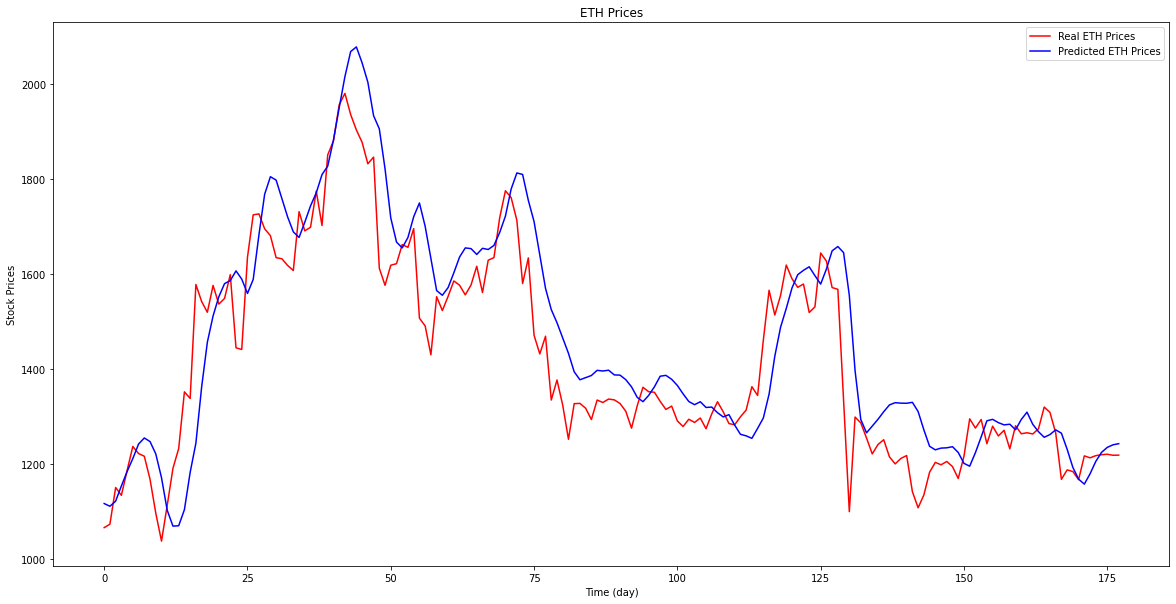

In [ ]:
# Ploting the stat
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1,1)
real_price = np.array(real_price)
print(real_price.shape)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.figure(figsize=(20,10))
plt.plot(real_price, color="red", label=f"Real ETH Prices") # real price line
plt.plot(predict_price, color="blue", label=f"Predicted ETH Prices") # predict_price line
plt.title(f"ETH Prices") # naming chart
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.legend() #note
plt.show()

In [ ]:
# Make Prediction
x_predict = df[len(df)-pre_day:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scala_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))

prediction = model.predict(x_predict)
prediction = scala_y.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 26ms/step
[[1242.2806]]


In [ ]:
mae = mean_absolute_error(real_price, predict_price)
mape = mean_absolute_percentage_error(real_price, predict_price)
mse = mean_squared_error(real_price, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 77.30
MAPE: 5.53%
MSE: 11292.13
RMSE: 106.26
R2: 0.75
